## PDS Price Predictor

Why is a Yellow Taxi Cab from the Empire State Building to Times Square $20? In this project, we will explore the justifications behind the pricing of Yellow Taxi Cabs in New York City.
By understanding the relevant features associated with a ride, we can develop a model that estimates how much a particular Yellow Taxi Cab ride will cost. Finally, using our model, we will directly compare the prices an Uber and a Yellow Taxi Cab would charge for the same trip in New York City. Our ultimate goal is to provide users with recommendations on which taxi service, Uber or Yellow Taxi Cab, to take for a given trip in New York City. 

<img src="https://github.com/ComputAni/PDS-Price-Predictor/raw/master/UberVsTaxi.jpg">

### Table of Contents

- [Introduction](#Introduction)
- [Getting the Data](#Getting-the-Data)
- [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Linear Model Take 1](#Linear-Model-Take-1)
- [Gradient Boosting Model](#Gradient-Boosting-Model)
- [PCA](#PCA)
- [Compare and Contrast with Uber](#Compare-and-Contrast-with-Uber)

First, install the geopy and sodapy modules via `pip`:
    
    $ pip install geopy
    
    $ pip install sodapy
    
Next, make sure the following imports work for you:

In [4]:
# Basic Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv, requests, re
from bs4 import BeautifulSoup
from unicodedata import normalize
%matplotlib inline
# Data
from sodapy import Socrata
# Machine Learning Modules
import scipy.stats as stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
# Geopy
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
# Datetime, Holiday imports
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar

## Introduction

## Getting the Data

We use a dataset sampled from NYC Open Data's 2016 Yellow Taxi Trip Data, which includes trip records from all trips completed in yellow taxis from in NYC from January to June 2016. Records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations (latitude and longitude), trip distances, and much more. For more information, check out: https://data.cityofnewyork.us/Transportation/2016-Yellow-Taxi-Trip-Data/k67s-dv2t. 

We use the NYC Open Data API: https://dev.socrata.com/foundry/data.cityofnewyork.us/uacg-pexx to request a sample dataset of 1000000 Yellow Taxi Cab trip records. First, we create a Socrata client object below, passing `None` for the second argument since we only need to create an unauthenticated client for access to the public data. 

In [5]:
client = Socrata("data.cityofnewyork.us", None)

In [ ]:
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
max_size = 50000
total_size = 1000000
num_chunks = total_size // max_size #Should be 200
total_data = []
print("Requesting: %d chunks" % num_chunks);
for i in range(num_chunks):
    curr_offset = max_size*i
    results = client.get("uacg-pexx", limit=50000, offset=curr_offset)
    total_data += results

In [ ]:
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(total_data)
print("Before scrubbing data size: ", len(results_df))
results_df = results_df[results_df.pickup_latitude != '0']
results_df = results_df[results_df.pickup_longitude != '0']
results_df = results_df[results_df.dropoff_latitude != '0']
results_df = results_df[results_df.dropoff_longitude != '0']
print("After scrubbing data size: ", len(results_df))

"""
dlen = len(results_df)
results_p1 = results_df.iloc[: dlen // 2]
results_p2 = results_df.iloc[dlen // 2:]
print(len(results_p1), len(results_p2))
#Write to csv file
results_p1.to_csv('cab_data_p1.csv')
results_p2.to_csv('cab_data_p2.csv')
"""
results_df.to_csv('cab_data.csv')


print("Finished writing to file!")

## Feature Engineering

First, load the scraped dataset. 

In [2]:
cab_data = pd.read_csv("cab_data.csv")

Next, we need to scrub the data of any uneccessary features, as well as make sure the values are correct.

In [3]:
#Removes uneccesary columns, as we will be creating our own features.
def scrub_df(df):
    #del df['extra']
    del df['fare_amount']
    del df['improvement_surcharge']
    del df['mta_tax']
    del df['passenger_count']
    del df['payment_type']
    del df['ratecodeid']
    del df['store_and_fwd_flag']
    del df['tip_amount']
    del df['tolls_amount']
    del df['trip_distance']
    del df['vendorid']
    
    return df

In [4]:
#Clean the input dataset of columns we don't care about
basic_df = scrub_df(cab_data)

Next, the distance of each trip is an important feature that affects price. Calculate the geo distance between two lat/lon pairs.

In [5]:
#Init the geolocator for caluclating distances
geolocator = Nominatim()

#Pairs the lat/lon columns into one column (for walkscore/geolocator)
def get_latlng(df):
    def f(x,y):
        coord = "%f, %f" % (x, y)
        return coord
    
    df['start_latlng'] = df[['dropoff_latitude', 'dropoff_longitude']].apply(lambda x: f(*x), axis=1)
    df['end_latlng'] = df[['pickup_latitude', 'pickup_longitude']].apply(lambda x: f(*x), axis=1)
    
    return df

#Given input dataframe, computes distance of trip using geolocator and start/end lat/lon positions
def get_dist(df):

    def get_d(x,y):
        return geodesic(x, y).miles

    df['distance'] = df[['start_latlng', 'end_latlng']].apply(lambda x: get_d(*x), axis=1)
    
    return df

In [6]:
df_with_latlng = get_latlng(basic_df)
df_with_dist = get_dist(df_with_latlng)

Furthermore, we found that particular date trends, such as time of day, holidays, and other date specific characteristics could potentially affect demand of Ubers, and therefore price. 
Specifically, we decomposed each cab query into years, months, days, hours, minutes, seconds, day of week, and whether or not it is a holiday.

In [7]:
def create_date_features(df, start_date, end_date):
    dt_format = '%Y-%m-%dT%H:%M:%S.%f'
    # Get the list of US federal hollidays
    cal = USFederalHolidayCalendar()
    us_holidays = cal.holidays(start=start_date, end=end_date).to_pydatetime()
    
    date_feature_names = ["tpep_dropoff_datetime", "tpep_pickup_datetime"]
    date_feature_to_datetimes = {"tpep_dropoff_datetime" : [],
                                 "tpep_pickup_datetime" : []}
    for feature_name in date_feature_names:
        y, mo, d = [], [], [] # Year, Month, Day
        h, mi, s = [], [], [] # Hours, Minutes, Seconds
        day_of_week = [] # Day of the Week
        is_holiday = [] # Is the date a holiday?
        for time in df[feature_name]:
            # Extract the datetime object from the timestamp
            dt = datetime.strptime(time, dt_format)
            date_feature_to_datetimes[feature_name].append(dt)
            # Add the Year/Month/Day
            y.append(dt.year)
            mo.append(dt.month)
            d.append(dt.day)
            # Add Hour/Minute/Second
            h.append(dt.hour)
            mi.append(dt.minute)
            s.append(dt.second)
            # Add Day of the Week
            day_of_week.append(dt.weekday())
            # Add is_holiday
            y_m_d = datetime(dt.year, dt.month, dt.day)
            is_holiday.append(1 if y_m_d in us_holidays else 0)
        df[feature_name + "_years"] = y
        df[feature_name + "_months"] = mo
        df[feature_name + "_days"] = d
        df[feature_name + "_hours"] = h
        df[feature_name + "_minutes"] = mi
        df[feature_name + "_seconds"] = s
        df[feature_name + "_day_of_week"] = day_of_week
        df[feature_name + "_is_holiday"] = is_holiday
    durations = []
    for dropoff_time, pickup_time in zip(date_feature_to_datetimes["tpep_dropoff_datetime"],
                                         date_feature_to_datetimes["tpep_pickup_datetime"]):
        duration = (dropoff_time - pickup_time).total_seconds() / 60.0
        durations.append(round(duration))
    
    df["duration"] = durations
    return df

In [30]:
#Generate the new dataframe with date features
start = '2016-01-01'
end = '2016-12-31'
df_with_date = create_date_features(df_with_dist, start, end)

#Write to temporary CSV file for holding
#df_with_date.to_csv("date_data.csv")

Lastly, we also found that weather patterns have an effect on usage of transportation. Consider the case of rain, users are less likely to walk/bike longer distances if it's raining, thereby increasing demand for taxi services. Other important features included snow level, percipitation, temperature, humidity, visibility, & dew point.

In [43]:
# Get weather data for 2016 and returns dictionary of date features
# Scrapes wunderground.com weather information for greater NY area.
def init_weather_features(start_date, end_date):
    date = start_date
    date_to_features = dict()
    # weather related features to extract
    feature_names = ["Mean Temperature",
                    "Max Temperature",
                    "Min Temperature",
                    "Dew Point",
                    "Average Humidity",
                    "Precipitation",
                    "Snow",
                    "Wind Speed",
                    "Visibility"]
    while (date <= end_date):
        # station: KNYC (Central Park, New York)
        (year, month, day) = (date.year, date.month, date.day)
        #print(year, month, day)

        # Get the HTML of the weather webpage
        url_format_string = "http://www.wunderground.com/history/airport/KNYC/{year}/{month}/{day}/DailyHistory.html"
        url = url_format_string.format(year=year, month=month, day=day)
        response = requests.get(url)

        if response.status_code != 200:
            print("An error occurred while getting NYC weather data for {day}-{month}-{year}".format(
            year=year, month=month, day=day))
        else:
            features = dict()
            html = response.content
            soup = BeautifulSoup(html, "lxml")
            table = soup.find_all(attrs={'id': 'historyTable'})[0]

            table_rows = table.find_all('tr')
            feature_list = []
            found_features = [False, False, False, False, False, False, False, False, False]
            # Loop through the entries of the table to find weather features
            for tr in table_rows:
                td = tr.find_all('td')
                # normalize the text to account for string encoding
                row = [normalize('NFKD', i.text) for i in td]

                # There are multiple rows named 'snow' and 'precipitation'
                # Use len(row) > 2 to get the "right" rows
                if len(row) > 2 and row[0] in feature_names:
                    data = row[1].strip() # remove extraneous whitespace
                    result = re.sub('[^0-9.]','', data) # remove all alphabetic characters
                    if result == "": # if there's no feature value (e.g.: T, for traces of precipitation/snow)
                        result = 0
                    features[row[0]] = result
                    found_features[feature_names.index(row[0])] = True
                    feature_list.append(result)

            # If a feature is not present in the table, set it to a default value: 0
            for found_feature, feature_name in zip(found_features, feature_names):
                if (not found_feature):
                    features[feature_name] = 0
            assert(len(features) == len(feature_names))
            date_to_features[date] = features
        date = date + timedelta(1)
        
    return date_to_features

# insert method for dictionary (list of values for each key)
def dict_insert(d, key, val):
    if key in d:
        d[key].append(val)
    else:
        d[key] = [val]

# put the weather-related features into the dataframe
def create_weather_features(df, date_to_features):
    
    dt_format = '%Y-%m-%dT%H:%M:%S.%f'
    weather_features = dict()
    for time in df["tpep_dropoff_datetime"]:
        # Extract the datetime object from the timestamp
        dt = datetime.strptime(time, dt_format)
        y_m_d = datetime(dt.year, dt.month, dt.day)
        weather_dict = date_to_features[y_m_d]
        for feature_name in weather_dict:
            dict_insert(weather_features, feature_name, weather_dict[feature_name])
        
    for feature_name in weather_features:
        df[feature_name] = weather_features[feature_name]
    return df

In [45]:
#Initialize the weather scraping function over the year of 2016
start_date = datetime(2016, 1, 1)
end_date = datetime(2016, 12, 31)
date_features = init_weather_features(start_date, end_date)

#Open our previously curated date related features and append our new weather features.
open_date_df = pd.read_csv("date_data.csv")
df_with_weather = create_weather_features(open_date_df, date_features)

Great! We now have a dataframe with a core set of features. Let's save it to a file! The next step is to take a closer look at our input data through an exploratory data analysis.

In [46]:
df_with_weather.head()
df_with_weather.to_csv('data_with_features.csv')

,Unnamed: 0,Unnamed: 0.1,dropoff_latitude,dropoff_longitude,pickup_latitude,pickup_longitude,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,start_latlng,...,duration,Mean Temperature,Max Temperature,Min Temperature,Dew Point,Average Humidity,Precipitation,Snow,Wind Speed,Visibility
0,0,0,40.777241,-73.951744,40.776424,-73.952850,15.35,2016-04-03T00:09:40.000,2016-04-02T23:55:45.000,"40.777241, -73.951744",...,14,42,50,34,16,51,0.09,0,13,10
1,1,1,40.777611,-73.951080,40.789371,-73.943352,12.30,2016-04-22T09:45:11.000,2016-04-22T09:27:51.000,"40.777611, -73.951080",...,17,71,79,62,53,55,0,0.00,4,10
2,2,2,40.770386,-73.966476,40.761303,-73.973183,5.80,2016-04-29T20:26:47.000,2016-04-29T20:23:57.000,"40.770386, -73.966476",...,3,52,58,45,34,48,0.05,0.00,6,10
3,3,3,40.767288,-73.966675,40.764381,-73.995583,10.80,2016-04-08T11:21:10.000,2016-04-08T11:10:26.000,"40.767288, -73.966675",...,11,45,50,40,26,48,0.01,0.00,7,10
4,4,4,40.744068,-73.988991,40.754742,-73.979820,7.30,2016-04-28T09:09:32.000,2016-04-28T09:04:28.000,"40.744068, -73.988991",...,5,54,59,48,30,51,0.00,0.00,5,10


## Exploratory Data Analysis

First, load the dataset using pandas.

In [8]:
cab_data = pd.read_csv("data_with_features.csv")
del cab_data["Unnamed: 0"] # Delete extraneous columns
del cab_data["Unnamed: 0.1"]
del cab_data["Unnamed: 0.1.1"]
cab_data.head()

,dropoff_latitude,dropoff_longitude,pickup_latitude,pickup_longitude,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,start_latlng,end_latlng,distance,...,duration,Mean Temperature,Max Temperature,Min Temperature,Dew Point,Average Humidity,Precipitation,Snow,Wind Speed,Visibility
0,40.777241,-73.951744,40.776424,-73.952850,15.35,2016-04-03T00:09:40.000,2016-04-02T23:55:45.000,"40.777241, -73.951744","40.776424, -73.952850",0.080895,...,14,42,50,34,16,51,0.09,0.0,13,10
1,40.777611,-73.951080,40.789371,-73.943352,12.30,2016-04-22T09:45:11.000,2016-04-22T09:27:51.000,"40.777611, -73.951080","40.789371, -73.943352",0.907077,...,17,71,79,62,53,55,0.00,0.0,4,10
2,40.770386,-73.966476,40.761303,-73.973183,5.80,2016-04-29T20:26:47.000,2016-04-29T20:23:57.000,"40.770386, -73.966476","40.761303, -73.973183",0.718773,...,3,52,58,45,34,48,0.05,0.0,6,10
3,40.767288,-73.966675,40.764381,-73.995583,10.80,2016-04-08T11:21:10.000,2016-04-08T11:10:26.000,"40.767288, -73.966675","40.764381, -73.995583",1.529830,...,11,45,50,40,26,48,0.01,0.0,7,10
4,40.744068,-73.988991,40.754742,-73.979820,7.30,2016-04-28T09:09:32.000,2016-04-28T09:04:28.000,"40.744068, -73.988991","40.754742, -73.979820",0.879828,...,5,54,59,48,30,51,0.00,0.0,5,10


Inspecting the data, we notice that there are some trips that have prices less than 0! We remove rows with negative prices below.

In [9]:
price_filter = cab_data["total_amount"] > 0
cab_data = cab_data[price_filter]

While conducting EDA, we can examine the continuous features using histograms. For example, here's a histogram showing the distribution of the `total_amount` variable.

(array([  7.90136000e+05,   1.33736000e+05,   3.83690000e+04,
          1.77190000e+04,   1.60100000e+03,   7.48000000e+02,
          2.43000000e+02,   1.45000000e+02,   6.20000000e+01,
          5.60000000e+01,   2.80000000e+01,   2.20000000e+01,
          9.00000000e+00,   9.00000000e+00,   8.00000000e+00,
          8.00000000e+00,   4.00000000e+00,   3.00000000e+00,
          5.00000000e+00,   1.00000000e+00,   4.00000000e+00,
          3.00000000e+00,   7.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

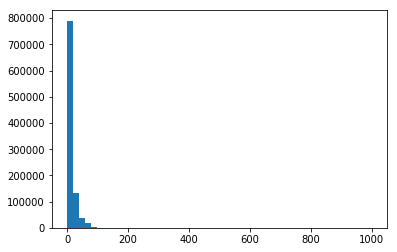

In [10]:
plt.hist(cab_data["total_amount"], bins=50)

The histogram of the price feature is quite skewed: there seem to be a lot of trips with relatively low prices and a long-tail of trips with very high prices. This suggests that a linear model will be a poor fit, since a linear model attempts to fit a Gaussian to the price.

((array([-4.82353497, -4.64362929, -4.54636112, ...,  4.54636112,
          4.64362929,  4.82353497]),
  array([  1.00000000e-02,   3.00000000e-01,   3.00000000e-01, ...,
           6.77800000e+02,   7.25300000e+02,   9.98300000e+02])),
 (10.824147811952644, 15.880819636273369, 0.8056246770820028))

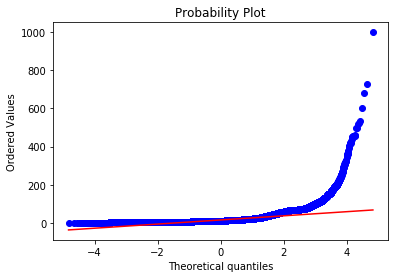

In [11]:
stats.probplot(cab_data["total_amount"], dist="norm", plot=plt)

We try a log transform of the price feature below.

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.06000000e+02,
          3.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   6.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          1.30000000e+01,   3.66800000e+03,   1.51370000e+04,
          6.38880000e+04,   1.19399000e+05,   1.72432000e+05,
          1.65874000e+05,   1.45312000e+05,   1.04177000e+05,
          6.68720000e+04,   3.99420000e+04,   2.62050000e+04,
          2.33850000e+04,   1.82050000e+04,   1.51790000e+04,
          1.65200000e+03,   8.48000000e+02,   2.76000000e+02,
          1.24000000e+02,   6.00000000e+01,   2.40000000e+01,
          1.50000000e+01,   1.70000000e+01,   4.00000000e+00,
        

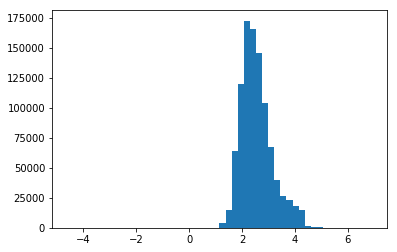

In [12]:
cab_data["log_total_amount"] = np.log(cab_data["total_amount"] + 1)
plt.hist(np.log(cab_data["total_amount"]), bins=50)

The plot above looks more normal, as evidenced by the qq plot below.

((array([-4.82353497, -4.64362929, -4.54636112, ...,  4.54636112,
          4.64362929,  4.82353497]),
  array([ 0.00995033,  0.26236426,  0.26236426, ...,  6.52032653,
          6.58796315,  6.90705503])),
 (0.53922967709458047, 2.6428798090460202, 0.97236933129257075))

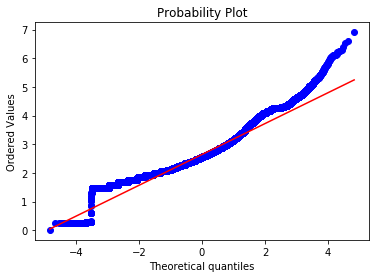

In [13]:
stats.probplot(cab_data["log_total_amount"], dist="norm", plot=plt)

Next, let's create a scatter plot of the price vs. the distance (miles) of the trip.

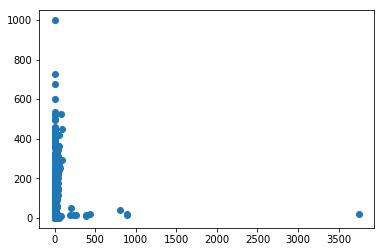

In [14]:
plt.scatter(cab_data["distance"], cab_data["total_amount"])

## Linear Model Take 1

Our first step is to define the subset of features from the original dataset that we wish to use in creating a price model.

In [15]:
feature_names = ['distance', 'duration', 'tpep_dropoff_datetime_years', 'tpep_dropoff_datetime_months',
       'tpep_dropoff_datetime_days', 'tpep_dropoff_datetime_hours',
       'tpep_dropoff_datetime_minutes', 'tpep_dropoff_datetime_seconds',
       'tpep_dropoff_datetime_day_of_week',
       'tpep_dropoff_datetime_is_holiday', 'tpep_pickup_datetime_years',
       'tpep_pickup_datetime_months', 'tpep_pickup_datetime_days',
       'tpep_pickup_datetime_hours', 'tpep_pickup_datetime_minutes',
       'tpep_pickup_datetime_seconds', 'tpep_pickup_datetime_day_of_week',
       'tpep_pickup_datetime_is_holiday', 'Mean Temperature',
       'Max Temperature', 'Min Temperature', 'Dew Point',
       'Average Humidity', 'Precipitation', 'Snow', 'Wind Speed',
       'Visibility']

Next, create a numpy array holding the examples from our dataset. For each example, we extract the features defined above.

In [16]:
def create_features(df, feature_names):
    features = []
    for feature_name in feature_names:
        features.append(df[feature_name])
    
    X = np.array(features).T
    y = df["log_total_amount"].values
    return (X,y)

(X,y) = create_features(cab_data, feature_names)

Next, we partition the data into training and testing splits, and further partition the training data into training and cross-validation splits.

In [17]:
def create_train_test_split(X,y):
    X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
    X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size = 0.3, random_state=0)
    
    return (X_train, y_train, X_cv, y_cv, X_test, y_test)

(X_train, y_train, X_cv, y_cv, X_test, y_test) = create_train_test_split(X,y)

Finally, we build a simple linear model on the training data and evaluate its performance by computing the mean squared error on the validation data. 

In [18]:
def train_linear_regression(X_train, y_train, X_test, y_test):
    model = linear_model.LinearRegression(fit_intercept=True, normalize=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Mean squared error: %.5f"
          % mean_squared_error(y_test, y_pred))
    return (model, y_pred)

(model, y_pred) = train_linear_regression(X_train, y_train, X_cv, y_cv)

Mean squared error: 0.10979


In [19]:
def predict(df, model):
    (X,y) = create_features(df)
    y_pred = model.predict(X)
    y_actual = df["log_total_amount"].values
    return y_pred, y_actual

In [20]:
def filter_data(cab_data):
    cab_data = cab_data[cab_data["total_amount"] >= 0]
    cab_data = cab_data[cab_data["total_amount"] <= 50]
    
    cab_data = cab_data[cab_data["distance"] >= 0]
    cab_data = cab_data[cab_data["distance"] <= 100]
    
    cab_data = cab_data[cab_data['dropoff_latitude'] >= 40.4]
    cab_data = cab_data[cab_data['dropoff_latitude'] <= 41]
    cab_data = cab_data[cab_data['dropoff_longitude'] >= -74.3]
    cab_data = cab_data[cab_data['dropoff_longitude'] <= -73.5]
    
    cab_data = cab_data[cab_data['pickup_latitude'] >= 40.4]
    cab_data = cab_data[cab_data['pickup_latitude'] <= 41]
    cab_data = cab_data[cab_data['pickup_longitude'] >= -75]
    cab_data = cab_data[cab_data['pickup_longitude'] <= -72]
    
    return cab_data
cab_data = filter_data(cab_data)

In [21]:
(X,y) = create_features(cab_data, feature_names)
(X_train, y_train, X_cv, y_cv, X_test, y_test) = create_train_test_split(X,y)
(model, y_pred) = train_linear_regression(X_train, y_train, X_cv, y_cv)

Mean squared error: 0.06454


## Gradient Boosting Model

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

clf = GradientBoostingRegressor()
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [43]:
print("Training MSE: ", np.mean((clf.predict(X_train) - y_train)**2))
print("Baseline training MSE: ", np.mean((np.mean(y_train) - y_train)**2))

Training MSE:  0.0155140948981
Baseline training MSE:  0.223299264109


In [44]:
print("CV MSE: ", np.mean((clf.predict(X_cv) - y_cv)**2))
print("Baseline CV MSE: ", np.mean((np.mean(y_train) - y_cv)**2))

CV MSE:  0.0156928642345
Baseline CV MSE:  0.222950525042


In [45]:
print("Test MSE: ", np.mean((clf.predict(X_test) - y_test)**2))
print("Baseline Test MSE: ", np.mean((np.mean(y_train) - y_test)**2))

Test MSE:  0.0156160411828
Baseline Test MSE:  0.22328588427


Below is a graph showing the training and testing MSE as a function of sample size. Notice that, interestingly, we get close to MSE of 0.04 on the validation set even after fitting a model on just the first 1000 samples!

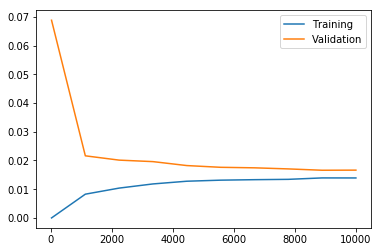

In [46]:
def get_err_samples(clf, X, y, X_cv, y_cv, n_samples):
    clf.fit(X[:n_samples], y[:n_samples])
    return np.array([np.mean((clf.predict(X[:n_samples]) - y[:n_samples])**2), 
                     np.mean((clf.predict(X_cv) - y_cv)**2)])

n_samples = [int(x) for x in np.linspace(20, 10000, 10)] # 1000, 2000, ..., 10000
errors = np.array([get_err_samples(clf, X_train, y_train, X_cv, y_cv, n) for n in n_samples])
plt.plot(n_samples, errors[:,0], n_samples, errors[:,1])
plt.legend(["Training", "Validation"])

## PCA

## Compare and Contrast with Uber

In [47]:
X_test = pd.read_csv('price_features.csv')
del X_test['i']
del X_test['tpep_dropoff_datetime']
del X_test['tpep_pickup_datetime']
model_results = clf.predict(X_test)

In [48]:
uber_pricing_estimates = []
with open('price_estimates.csv', 'r') as f:
    r = csv.reader(f)
    uber_pricing_estimates = list(r)

uber_pricing_estimates.pop(0)

['min_estimate', ' max_estimate', ' avg_estimate']

In [49]:
assert(len(model_results) == len(uber_pricing_estimates))

for i in range(len(model_results)):
    uber_hi, uber_lo, uber_avg = uber_pricing_estimates[i]
    #Weird formatting stuff, ignore for now
    uber_avg = uber_avg[:len(uber_avg)-1]
    uber_hi = uber_hi[1:]

    our_estimate = model_results[i]
    
    print("For trip %d, Model: %f Uber: %s" % (i, np.exp(our_estimate) - 1, uber_avg))

For trip 0, Model: 17.383021 Uber:  15.0
For trip 1, Model: 19.705704 Uber:  20.5
For trip 2, Model: 22.013139 Uber:  62.0
For trip 3, Model: 11.886965 Uber:  13.0
For trip 4, Model: 13.222841 Uber:  12.5
For trip 5, Model: 12.499772 Uber:  9.5
For trip 6, Model: 8.502926 Uber:  9.5
For trip 7, Model: 15.662806 Uber:  17.0
For trip 8, Model: 14.926886 Uber:  15.0
For trip 9, Model: 27.800741 Uber:  54.0
For trip 10, Model: 7.680865 Uber:  9.5
For trip 11, Model: 8.050829 Uber:  9.5
For trip 12, Model: 12.435391 Uber:  11.5
For trip 13, Model: 7.639781 Uber:  9.5
For trip 14, Model: 11.748040 Uber:  55.0
For trip 15, Model: 6.424799 Uber:  12.0
For trip 16, Model: 13.233054 Uber:  14.0
For trip 17, Model: 12.642122 Uber:  10.5
For trip 18, Model: 7.695773 Uber:  9.5
For trip 19, Model: 7.695773 Uber:  9.5
For trip 20, Model: 20.873591 Uber:  18.0
For trip 21, Model: 17.542217 Uber:  16.0
For trip 22, Model: 25.820370 Uber:  26.0
For trip 23, Model: 6.711237 Uber:  9.5
For trip 24, Model